In [1]:
#Import Python packages that are used for the WOfS feature layers analysis.
%matplotlib inline
import datacube
import seaborn as sns
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map, xr_animation
from datacube.utils import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from deafrica_tools.plotting import display_map, plot_wofs
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs

In [2]:
#Connect to datacube for storing WOfS feature layers
dc = datacube.Datacube(app="Intro_WOfS")

In [3]:
#Load product wofs_ls feature layers
products = dc.list_products()
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs_ls")]

,name,description
name,,
wofs_ls,wofs_ls,Historic Flood Mapping Water Observations from...
wofs_ls_summary_alltime,wofs_ls_summary_alltime,Water Observations from Space Alltime Statistics
wofs_ls_summary_annual,wofs_ls_summary_annual,Water Observations from Space Annual Statistics


In [4]:
#define studt area and period
start_year = '1985'
end_year = '2021'
lat, lon =  0.632055, 36.05672
buffer = 0.15
time_range = (start_year, end_year)
#add lat,lon,buffer togethert to get bounding box
x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

In [5]:
# View the location 
display_map(x=x, y=y)

In [6]:
# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ("1985"),
    'resolution': (-30, 30)
}
#grab crs of location
output_crs = mostcommon_crs(dc=dc, product='wofs_ls', query=query)
# Load WOfS feature layers 
wofls= dc.load(product = 'wofs_ls',
               group_by="solar_day",
               fuse_func=wofs_fuser,
               output_crs = output_crs,
               collection_category="T1",
               **query)
wofls

/home/jovyan/.local/lib/python3.10/site-packages/deafrica_tools/datahandling.py:733: UserWarning: Multiple UTM zones ['epsg:32636', 'epsg:32637'] were returned for this query. Defaulting to the most common zone: epsg:32636
  warnings.warn(


<xarray.Dataset>
Dimensions:      (time: 3, y: 1108, x: 1116)
Coordinates:
  * time         (time) datetime64[ns] 1985-01-09T07:18:52.113069 ... 1985-04...
  * y            (y) float64 8.656e+04 8.654e+04 ... 5.338e+04 5.336e+04
  * x            (x) float64 8.235e+05 8.236e+05 8.236e+05 ... 8.57e+05 8.57e+05
    spatial_ref  int32 32636
Data variables:
    water        (time, y, x) uint8 16 16 0 0 0 0 0 0 ... 64 64 64 64 64 64 64
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

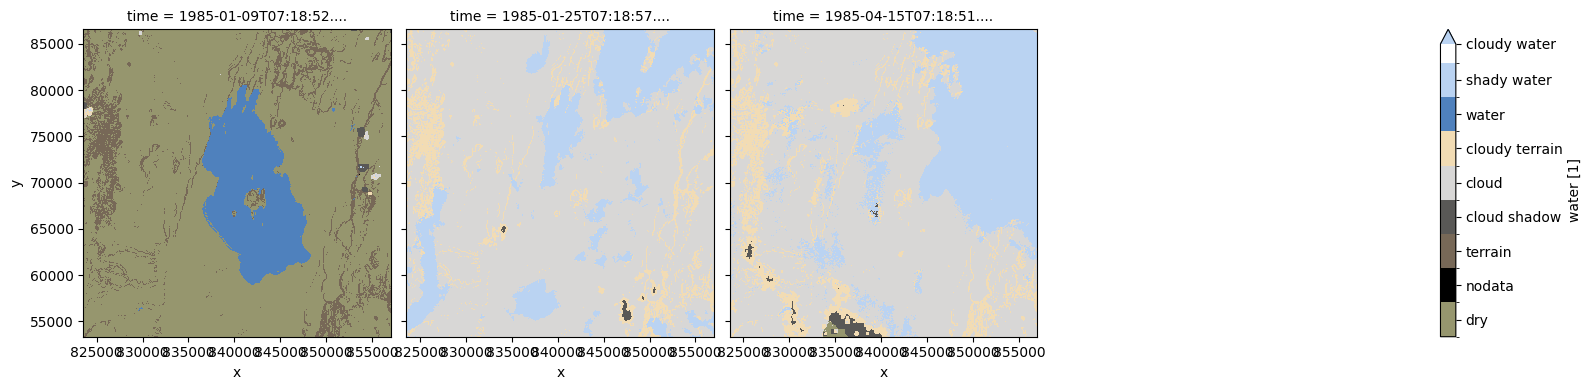

In [7]:
# Classify different types of data in the area of interest
plot_wofs(wofls.water, col='time', size=4, col_wrap=4);

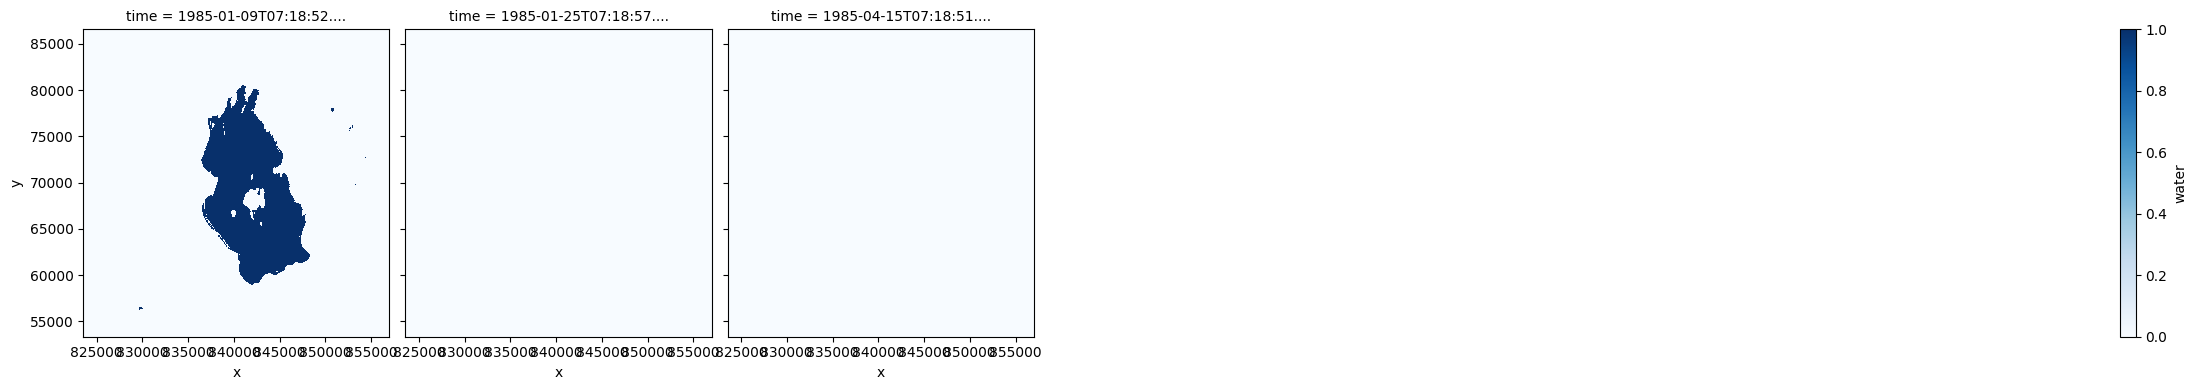

In [8]:
# Keeping only wet area, non-cloudy pixels
wofls_wet = masking.make_mask(wofls, wet=True)
# Plot output mask
wofls_wet.water.plot.pcolormesh(col='time', size=4, col_wrap=6,cmap='Blues');

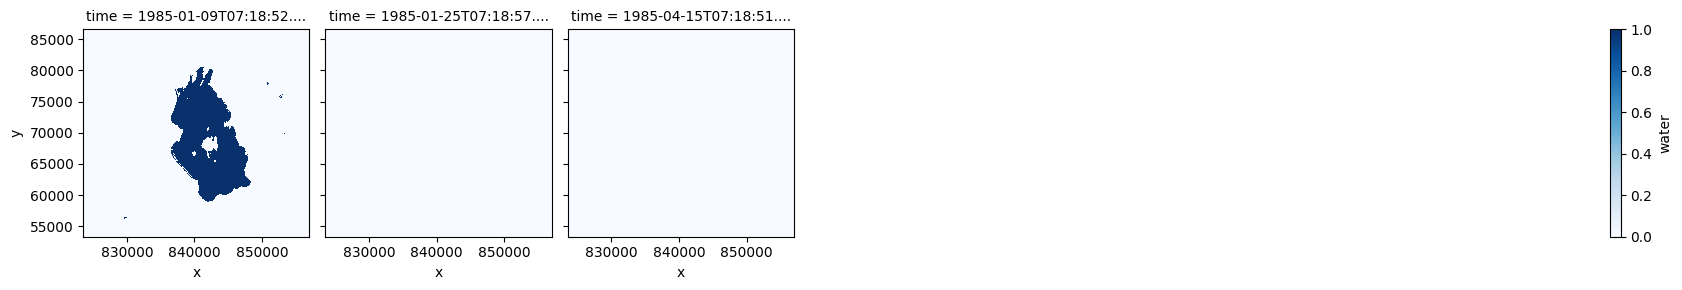

In [9]:
# Show areas flagged as water only (with no other flags set)
(wofls.water == 128).plot.imshow(col='time', col_wrap=6, cmap='Blues');

In [10]:
#Plot row660th of the first pic (list number 1) or year 1985
wofls.water[1][660].values

array([64, 64, 64, ..., 64, 64, 64], dtype=uint8)

In [11]:
#Load product wofs_ls_summary_alltime
wofs_alltime = dc.load(product='wofs_ls_summary_alltime', like=wofls.geobox)
wofs_alltime

<xarray.Dataset>
Dimensions:      (time: 1, y: 1108, x: 1116)
Coordinates:
  * time         (time) datetime64[ns] 2003-07-02T11:59:59.999999
  * y            (y) float64 8.656e+04 8.654e+04 ... 5.338e+04 5.336e+04
  * x            (x) float64 8.235e+05 8.236e+05 8.236e+05 ... 8.57e+05 8.57e+05
    spatial_ref  int32 32636
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 0 537 537 542 546 ... 404 406 409 409 407
    frequency    (time, y, x) float32 nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [13]:
#Plot frequency row500th of the all time summary layer
wofs_alltime.frequency[0][500]

<xarray.DataArray 'frequency' (x: 1116)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    time         datetime64[ns] 2003-07-02T11:59:59.999999
    y            float64 7.156e+04
  * x            (x) float64 8.235e+05 8.236e+05 8.236e+05 ... 8.57e+05 8.57e+05
    spatial_ref  int32 32636
Attributes:
    units:         1
    nodata:        nan
    crs:           PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

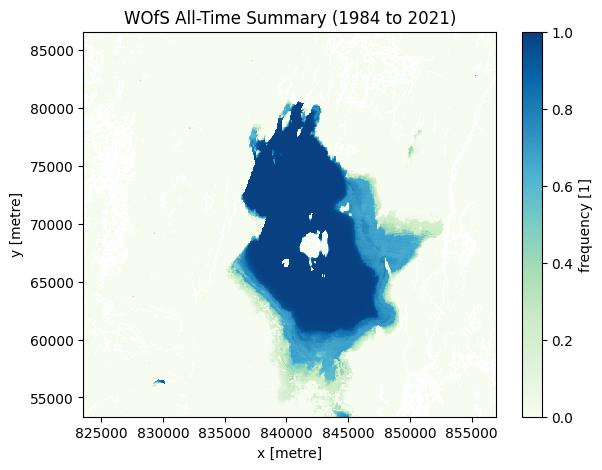

In [14]:
#Plot water frequency map of all-time summary
wofs_alltime.frequency.plot(size=5, cmap=sns.color_palette("GnBu", as_cmap=True))
plt.title('WOfS All-Time Summary (1984 to 2021)');

In [15]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing or saturated
low_solar_angle,2,"{'0': False, '1': True}",Low solar incidence angle
terrain_shadow,3,"{'0': False, '1': True}",Terrain shadow
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 4, 3, 2, 1, 0]",{'0': True},No water detected
wet,"[7, 6, 5, 4, 3, 2, 1, 0]",{'128': True},Clear and Wet
